# Positional encoding

In [1]:
pe_descs = ["learn-0.1", "learn-0.2", "learn-0.3", "learn-0.4", "learn-0.5",
            "learn-0.6", "learn-0.7", "learn-0.8", "learn-0.9", "learn-1.0",
            "learn-1.1", "learn-1.2", "learn-1.3", "learn-1.4", "learn-1.5",
            "learn-1.6", "learn-1.7", "learn-1.8", "learn-1.9", "learn-2.0"]


## Model performance

In [2]:
import lstnn.transformer_main as transformer_main
from lstnn.dataset import get_dataset
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr


LST_puzzle_ds = get_dataset('../data/nn/puzzle_data_original.csv')

# model parameters
dropout = 0.0
epoch = 4000 # final training step
layer = 4
attnhead = 1
wdecay = 0.0
model_label = 'BERT'
curriculum = 'All'
seeds = [2235, 6312, 6068, 9742, 8880, 2197, 669, 6256, 3309, 2541, 8643, 7785, 195, 6914, 29]

device = 'cpu'

# model params
nblocks = [4]
dropout = 0.0
hidden_size = 160 
learning_rate = 0.0001
training_acc_cutoff = 0.0
cutoff_length = 0  # how many epochs must the model sustain the accuracy cutoff?
last_epoch = 4000
checkpoint_freq = 200
df = []
for pe in pe_descs:
    #petype = 'absolute2d'
    #pestr = '2dpe'
    resultdir = f"/home/lukeh/LabData/Lab_LucaC/Luke/projects/LSTNN/data/ito_models/"
    modelname = f"model-{model_label}_" \
                f"pe-{pe}_" \
                f"nl-{layer}_" \
                f"do-{dropout}_" \
                f"wd-{wdecay}_" \
                f"at-{attnhead}_" \
                f"hs-{hidden_size}_" \
                f"curr-{curriculum}_" \
                f"lr-{learning_rate}_" \
                f"co-{training_acc_cutoff}_" \
                f"col-{cutoff_length}/"

    for seed in seeds:
        checkpoint = f"s-{seed}_" \
                    f"e-{epoch}"
        file = resultdir + modelname + checkpoint +'.csv'
        _df = pd.read_csv(file)
        _df['seed'] = seed
        _df["pe"] = pe
        df.append(_df)
df = pd.concat(df)
df.head()
performance_df = df.copy()

In [3]:
# data = df.loc[(df.epoch == 4000) & (df.condition == "average") & (df.phase == "validation")].groupby(["pe"]).mean(numeric_only=True).reset_index()
# #data[["a", "b"]] = df['pe'].str.split('-', n=1, expand=True)
# data.head()
# #data.plot.scatter("pe", "accuracy")
# x = data.pe.str.split("-", n=1, expand=True)
# x = x[1].values
# y = data.accuracy.values
# print(spearmanr(x,y))

# Basic performance plots

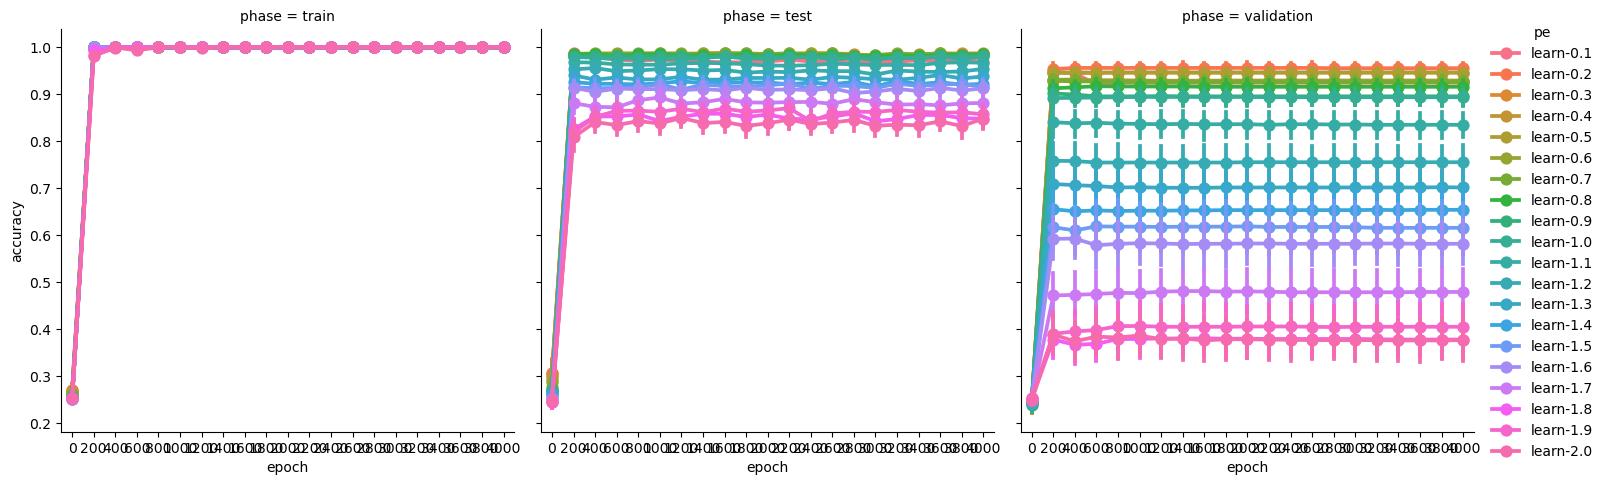

In [4]:
import seaborn as sns
sns.catplot(data=df, x="epoch", col="phase", hue="pe", y="accuracy", kind="point")

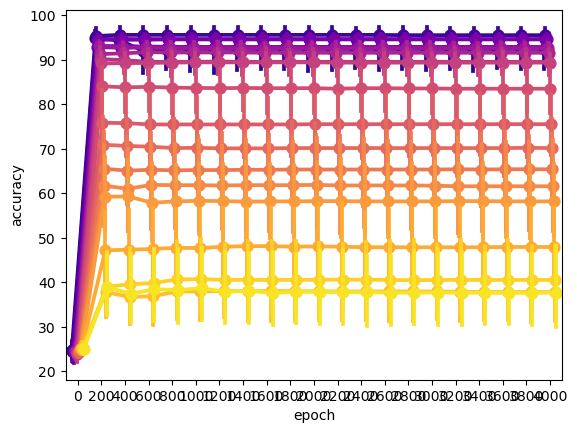

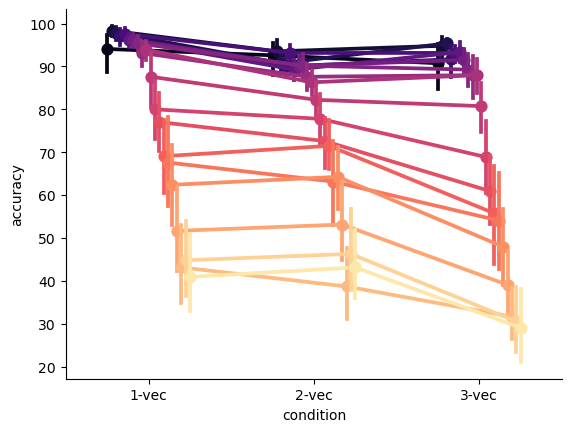

In [5]:
# plot condition-wise test
plot_df = df.loc[(df["phase"] == "validation")
                & (df['condition'] == 'average')].reset_index()
plot_df["accuracy"] = plot_df["accuracy"] * 100
plot_df.replace("binary", "1-vec", inplace=True)
plot_df.replace("ternary", "2-vec", inplace=True)
plot_df.replace("quaternary", "3-vec", inplace=True)
sns.pointplot(data=plot_df,
            x='epoch', y='accuracy', palette="plasma", hue="pe",dodge=True,
            legend=False)
plt.show()
# plot condition-wise test
plot_df = df.loc[(df["epoch"] == 4000)
                & (df["phase"] == "validation")
                & (df['condition'] != 'average')].reset_index()
plot_df["accuracy"] = plot_df["accuracy"] * 100
plot_df.replace("binary", "1-vec", inplace=True)
plot_df.replace("ternary", "2-vec", inplace=True)
plot_df.replace("quaternary", "3-vec", inplace=True)
sns.pointplot(data=plot_df,
            x='condition', y='accuracy', palette="magma", hue="pe",
            order=["1-vec", "2-vec", "3-vec"], dodge=True,
            legend=False)
# # parameters
# ax.tick_params(axis='both', which='major', labelsize=9)
# ax.set_ylabel("% Correct", fontsize=10, labelpad=-5)
# ax.set_xlabel("Condition", fontsize=10)
# ax.set_ylim([90, 101])
# ax.tick_params(axis='x', labelrotation=30)
sns.despine()
plt.show()

# Brain plots of PE anchors
Load results with lots of perms

In [6]:
import pandas as pd
import numpy as np
from lstnn.parcellation import Parcellation
import matplotlib.pyplot as plt
import seaborn as sns

# parameters
pe_desc = "2dpe"
fmethod = "crossnobis" # "crossnobis"
amethod = "euclidean" #  "euclidean"
cmethod = "corr" 
epoch = 4000
n_perms = 10000
atlas = "Glasser"

if atlas == "Glasser":
    cortex = 'Glasser'
    cortex_res = None
    scale = 1
elif atlas == "Schaefer":
    cortex = 'Schaefer'
    cortex_res = 400
    scale = 1

parc = Parcellation(cortex=cortex, cortex_res=cortex_res, scale=scale)

brain_pe_df = []
comparison_pes = ["learn-0.2", "learn-2.0"]
for pe_desc in comparison_pes:

    in_file = f"/home/lukeh/projects/LSTNN/results/model_comparison/group_atlas-{atlas}/pe-{pe_desc}"
    in_file += f"_fmethod-{fmethod}_amethod-{amethod}_cmethod-{cmethod}"
    in_file += f"_epoch-{epoch}_nperms-{n_perms}"
    brain_pe_df.append(pd.read_csv(in_file+"_stats.csv"))
brain_pe_df = pd.concat(brain_pe_df)

In [7]:
from tqdm import tqdm
from pingouin import multicomp
run = False
if run:
    df = []
    for pe_desc in comparison_pes:

        in_file = f"/home/lukeh/projects/LSTNN/results/model_comparison/group_atlas-{atlas}/pe-{pe_desc}"
        in_file += f"_fmethod-{fmethod}_amethod-{amethod}_cmethod-{cmethod}"
        in_file += f"_epoch-{epoch}_nperms-{n_perms}"
        data = pd.read_csv(in_file+".csv")
        data["pe"] = pe_desc
        df.append(data)

    df = pd.concat(df)

    # calculate differerence stats:

    # calculate p-values
    result = []
    for model in ["pe_avg", "attn_out_avg"]:
        print(model)
        a = df.loc[(df.model == model) & (df.pe == comparison_pes[0])]
        b = df.loc[(df.model == model) & (df.pe == comparison_pes[1])]
        a_real = a.loc[(a.permutation == False)]
        a_null = a.loc[(a.permutation == True)]
        b_real = b.loc[(b.permutation == False)]
        b_null = b.loc[(b.permutation == True)]

        diff_real = a_real.copy()
        diff_real["pe"] = "difference"
        diff_real["stat"] = a_real.stat - b_real.stat


        diff_null = a_null.copy()
        diff_null["pe"] = "difference"
        diff_null["stat"] = a_null.stat - b_null.stat

        data = []
        percentiles = []
        for parcel in tqdm(diff_real.parcel.unique()):
            value = diff_real.loc[(diff_real.parcel == parcel), "stat"].values[0]
            null_distribution = diff_null.loc[(diff_null.parcel == parcel), "stat"].values
            percentile = (null_distribution < value).mean()
            percentiles.append(percentile)
            #p_val = (0.5 - (abs(percentile - 0.5))) # Express similar to a p value regardless of direction
            p = 1 - percentile  # only investigate one direction
            data.append(p)

        # Don't analyse subcortical regions
        reject, p_corrected = multicomp(np.array(data[16::]), method="fdr_by")
        print(sum(reject))
        p_fdr = np.ones((len(data)))
        p_fdr[16::] = p_corrected
        diff_real["p_FDR"] = p_fdr.copy()
        diff_real["percentile"] = np.array(percentiles).copy()

        result.append(diff_real)
    result = pd.concat(result)
    brain_pe_df = pd.concat([brain_pe_df, result])

In [8]:
import nibabel as nb
import seaborn as sns
import hcp_utils as hcp
import nilearn.plotting as plotting
import matplotlib.pyplot as plt
import numpy as np
import cmasher as cmr

def pub_surf_plot(input_array, parcellation, save=None, size=(2.2, 2.2), thresh=None, vmin=None, vmax=None, cmap="viridis"):
    if vmax is None:
        vmax = np.nanmax(input_array)
    if vmin is None:
        vmin = np.nanmin(input_array)
    parc = np.squeeze(nb.load(parcellation).get_fdata())
    output = np.zeros((parc.shape))
    borders = np.zeros((parc.shape))
    parcels = np.unique(parc)
    parcels = np.delete(parcels, 0)  # assume 0 denotes no roi

    for i in parcels:
        index = (parc == i)
        output[index] = input_array[int(i)-1]
        borders[index] = i

    fig, axs = plt.subplot_mosaic("""
                              AB
                              CD
                              """,
                                  figsize=size, subplot_kw=dict(
                                      projection='3d'),
                                  constrained_layout=True)
    count = 0
    ax_list = ["A", "B", "C", "D"]
    darkness = 1.0
    alpha = 1.0
    for view in ['lateral', 'medial']:
        for hemi in ['left', 'right']:

            if hemi == 'left':
                surface = hcp.left_cortex_data(output)

                mesh = hcp.mesh.inflated_left
                bg_map = hcp.mesh.sulc_left

            elif hemi == 'right':
                surface = hcp.right_cortex_data(output)

                mesh = hcp.mesh.inflated_right
                bg_map = hcp.mesh.sulc_right

            if save is not None:
                plt.close("all")
                plotting.plot_surf_stat_map(mesh, surface, bg_map=bg_map, view=view, cmap=cmap, threshold=thresh,
                                            hemi=hemi, bg_on_data=True, darkness=darkness,
                                            alpha=alpha, vmax=vmax, vmin=vmin, colorbar=False, symmetric_cbar=False)
                plt.savefig(save+'_'+hemi+'_'+view+'.jpeg', dpi=600)
                plt.close("all")
                plotting.plot_surf_stat_map(mesh, surface, bg_map=bg_map, view=view, cmap=cmap, threshold=thresh,
                                            hemi=hemi, bg_on_data=True, darkness=darkness,
                                            alpha=alpha, vmax=vmax, vmin=vmin, colorbar=True, symmetric_cbar=False)
                plt.savefig(save+'_'+hemi+'_'+view+'_colorbar.jpeg', dpi=600)
                plt.close("all")

            else:

                ax = axs[ax_list[count]]

                plotting.plot_surf_stat_map(mesh, surface, bg_map=bg_map, view=view, cmap=cmap, threshold=thresh,
                                            hemi=hemi, bg_on_data=True, darkness=darkness, axes=ax,
                                            alpha=alpha, vmax=vmax, vmin=vmin, colorbar=False, symmetric_cbar=False)

            count = count+1

    plt.show()


def pub_surf_plot_contours(input_array, input_array2, parcellation, save=None, size=(2.2, 2.2), thresh=None, vmin=None, vmax=None, cmap="viridis"):
    if vmax is None:
        vmax = np.nanmax(input_array)
    if vmin is None:
        vmin = np.nanmin(input_array)
    parc = np.squeeze(nb.load(parcellation).get_fdata())
    output = np.zeros((parc.shape))
    output2 = np.zeros((parc.shape))
    #borders = np.zeros((parc.shape))
    parcels = np.unique(parc)
    parcels = np.delete(parcels, 0)  # assume 0 denotes no roi

    for i in parcels:
        index = (parc == i)
        output[index] = input_array[int(i)-1]
        output2[index] = input_array2[int(i)-1]
        #borders[index] = i

    fig, axs = plt.subplot_mosaic("""
                              AB
                              CD
                              """,
                                  figsize=size, subplot_kw=dict(
                                      projection='3d'),
                                  constrained_layout=True)
    count = 0
    ax_list = ["A", "B", "C", "D"]
    darkness = 1.0
    alpha = 1.0
    for view in ['lateral', 'medial']:
        for hemi in ['left', 'right']:

            if hemi == 'left':
                surface = hcp.left_cortex_data(output)
                surface2 = hcp.left_cortex_data(output2)
                mesh = hcp.mesh.inflated_left
                bg_map = hcp.mesh.sulc_left

            elif hemi == 'right':
                surface = hcp.right_cortex_data(output)
                surface2 = hcp.right_cortex_data(output2)
                mesh = hcp.mesh.inflated_right
                bg_map = hcp.mesh.sulc_right

            if save is not None:
                plt.close("all")
                plotting.plot_surf_stat_map(mesh, surface, bg_map=bg_map, view=view, cmap=cmap, threshold=thresh,
                                            hemi=hemi, bg_on_data=True, darkness=darkness,
                                            alpha=alpha, vmax=vmax, vmin=vmin, colorbar=False, symmetric_cbar=False)
                ax = plt.gca()
                for roi in np.unique(surface2)[1::]:
                    try:
                        plotting.plot_surf_contours(mesh, surface2, levels=[int(roi)], bg_map=bg_map, view=view, colors='k', hemi=hemi, bg_on_data=True, darkness=0.50, axes=ax)
                    except:
                        print("contour not plotting", hemi, view)
                plt.savefig(save+'_'+hemi+'_'+view+'.jpeg', dpi=600)
                plt.close("all")
                plotting.plot_surf_stat_map(mesh, surface, bg_map=bg_map, view=view, cmap=cmap, threshold=thresh,
                                            hemi=hemi, bg_on_data=True, darkness=darkness,
                                            alpha=alpha, vmax=vmax, vmin=vmin, colorbar=True, symmetric_cbar=False)
                plt.savefig(save+'_'+hemi+'_'+view+'_colorbar.jpeg', dpi=600)
                plt.close("all")

            else:
                ax = axs[ax_list[count]]

                plotting.plot_surf_stat_map(mesh, surface, bg_map=bg_map, view=view, cmap=cmap, threshold=thresh,
                                            hemi=hemi, bg_on_data=True, darkness=darkness, axes=ax,
                                            alpha=alpha, vmax=vmax, vmin=vmin, colorbar=False, symmetric_cbar=False)
                
                for roi in np.unique(surface2)[1::]:
                    try:
                        plotting.plot_surf_contours(mesh, surface2, levels=[int(roi)], bg_map=bg_map, view=view, colors='k', hemi=hemi, bg_on_data=True, darkness=0.50, axes=ax)
                    except:
                        print("contour not plotting", hemi, view)

            count = count+1

    plt.show()

def get_cropped_img(img,
                    x_start_buffer=10,
                    x_finish_buffer=10,
                    y_start_buffer=10,
                    y_finish_buffer=10,
                    ):
    # Returns a cropped input image

    # average across color information (3rd dimension)
    m_img = np.mean(img, axis=2)

    x_start = (np.where(np.argmax(m_img != np.max(img), axis=0))
               [0][0]) - x_start_buffer
    x_finish = (np.where(np.argmax(m_img != np.max(img), axis=0))
                [0][-1]) + x_finish_buffer
    y_start = np.where(np.argmax(m_img != np.max(img), axis=1))[
        0][0] - y_start_buffer
    y_finish = np.where(np.argmax(m_img != np.max(img), axis=1))[
        0][-1] + y_finish_buffer

    # Crop the input image based on determined crop heights and widths
    img_cropped = img[y_start:y_finish, x_start:x_finish, :]
    return img_cropped


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [9]:
def myround(x, base=0.05):
    return np.round(base * round(x/base), 2)

df = brain_pe_df.copy()
save = False
plot = False
cmap1 = cmr.sunburst
cmap2 = cmr.prinsenvlag_r
stat = "stat"
plot_data = np.zeros((4, parc.n_parcels))

for model in ["pe_avg", "attn_out_avg"]:
    for pe in comparison_pes:
        print(model, pe, stat)
        # suggested max val - changes across layers...
        #dmax = abs(max(df.loc[(df.pe == pe) & (df.model == model+"_"+str(layer)), stat].values)).round(2)

        # OR don't change across layers:
        dmax = abs(max(df.loc[(df.pe == pe) & (df.model == model), stat].values)).round(3)
        d_max_round = myround(dmax)
        print(dmax, d_max_round)
        plot_data = df.loc[(df.pe == pe) & (df.model == model), stat].values
        plot_data2 = df.loc[(df.pe == pe) & (df.model == model), "p_FDR"].values
        c = 1
        for i in range(len(plot_data2)):
            if plot_data2[i] < 0.05:
                plot_data2[i] = c
                c = c+1
            else:
                plot_data2[i] = 0
        if (cmethod == "corr") & (stat == "stat"):
            cmap = cmap2
        else:
            cmap = cmap1

        if (cmethod == "corr") & (stat == "stat"):
            vmin = d_max_round * -1
            vmax = d_max_round
        elif (cmethod == "cosine") & (stat == "stat"):
            vmin=None
            vmax=None
        else:
            vmin = 0
            vmax = 1

        # # actually, set some absolute limits for comparison
        # vmax = 0.25
        # vmin = -0.25
        
        if save:
            # pub_surf_plot(plot_data, parc.file, save=f"../figures/brain_plots/RSA-model-{model}_pe-{pe}_layer-{layer}_stat-{stat}", 
            #             size=(2.5, 2.2), thresh=0.000001, cmap=cmap, vmin=vmin, vmax=vmax)
            pub_surf_plot_contours(plot_data, plot_data2, parc.file, save=f"../figures/brain_plots/RSA-model-{model}_pe-{pe}_stat-{stat}_contoured", 
                        size=(2.5, 2.2), thresh=0.000001, cmap=cmap, vmin=vmin, vmax=vmax)
        if plot:
            
            #pub_surf_plot(np.array(plot_data), parc.file, save=None, size=(2.5, 2.2), thresh=0.000001, cmap=cmap, vmin=vmin, vmax=vmax)
            pub_surf_plot_contours(np.array(plot_data), np.array(plot_data2), parc.file, save=None, size=(2.5, 2.2), thresh=0.000001, cmap=cmap, vmin=vmin, vmax=vmax)

pe_avg learn-0.2 stat
0.236 0.25
pe_avg learn-2.0 stat
0.212 0.2
attn_out_avg learn-0.2 stat
0.209 0.2
attn_out_avg learn-2.0 stat
0.185 0.2


# Brain - PE contiuum relationship
 - Get region of interest from the main (2dpe) results and look at the overal brain-ANN alignment
 - Don't include unimodal results in attn, as they are the same as the PE results.

In [10]:
# get ROI
import pandas as pd
from lstnn.parcellation import Parcellation

# parameters
pe_desc = "2dpe"
n_perms = 10000
fmethod = "crossnobis" # "crossnobis"
amethod = "euclidean"
cmethod = "corr" 
epoch = 4000
atlas = "Glasser"

if atlas == "Glasser":
    cortex = 'Glasser'
    cortex_res = None
    scale = 1
elif atlas == "Schaefer":
    cortex = 'Schaefer'
    cortex_res = 400
    scale = 1
parc = Parcellation(cortex=cortex, cortex_res=cortex_res, scale=scale)

df_list = []
in_file = f"/home/lukeh/projects/LSTNN/results/model_comparison/group_atlas-{atlas}/pe-{pe_desc}"
in_file += f"_fmethod-{fmethod}_amethod-{amethod}_cmethod-{cmethod}"
in_file += f"_epoch-{epoch}_nperms-{n_perms}"
df_gt = pd.read_csv(in_file+"_stats.csv")

df_gt = df_gt.assign(simple_network=df_gt["network"])
for i in ["Visual1", "Visual2"]:
    df_gt["simple_network"] = df_gt["simple_network"].replace(i, "Unimodal")

for i in ["Frontoparietal", "Default", "Cingulo-Opercular", "Language"]:
    df_gt["simple_network"] = df_gt["simple_network"].replace(i, "Transmodal")


# load all the PE data
n_perms = 10
df_list = []
for pe_desc in pe_descs:
    in_file = f"/home/lukeh/projects/LSTNN/results/model_comparison/group_atlas-{atlas}/pe-{pe_desc}"
    in_file += f"_fmethod-{fmethod}_amethod-{amethod}_cmethod-{cmethod}"
    in_file += f"_epoch-{epoch}_nperms-{n_perms}_stats.csv"
    df_list.append(pd.read_csv(in_file))
pe_df = pd.concat(df_list)

pe_df = pe_df.assign(simple_network=pe_df["network"])
for i in ["Visual1", "Visual2"]:
    pe_df["simple_network"] = pe_df["simple_network"].replace(i, "Unimodal")

for i in ["Frontoparietal", "Default", "Cingulo-Opercular", "Language"]:
    pe_df["simple_network"] = pe_df["simple_network"].replace(i, "Transmodal")

pe_df.head()

,stat,permutation,compare_method,model,parcel,it,pe,fmethod,cmethod,amethod,epoch,p_FDR,percentile,network,simple_network
0,0.067595,False,corr,pe_layer0,HIP-rh,0,learn-0.1,crossnobis,corr,euclidean,4000,1.0,1.0,NaN,NaN
1,0.030235,False,corr,pe_layer1,HIP-rh,0,learn-0.1,crossnobis,corr,euclidean,4000,1.0,0.8,NaN,NaN
2,0.010958,False,corr,pe_layer2,HIP-rh,0,learn-0.1,crossnobis,corr,euclidean,4000,1.0,0.9,NaN,NaN
3,-0.001665,False,corr,pe_layer3,HIP-rh,0,learn-0.1,crossnobis,corr,euclidean,4000,1.0,0.6,NaN,NaN
4,0.030811,False,corr,pe_avg,HIP-rh,0,learn-0.1,crossnobis,corr,euclidean,4000,1.0,1.0,NaN,NaN


## Define and plot ROIs

In [11]:
# # find regions of interest based on 2dpe
# data = df_gt.loc[(df_gt.p_FDR < 0.05)
#               & (df_gt.model.str.startswith("ann_mlp"))
#               & ((df_gt.model.str.contains("_1")) | (df_gt.model.str.contains("_4")))]

# find regions of interest based on 2dpe
data = df_gt.loc[(df_gt.p_FDR < 0.05) & (df_gt.model == "attn_out_avg")]
# print(data[data.p_FDR < 0.05].parcel.to_list())
# print(data[data.p_FDR < 0.05].network.to_list())

attn_rois = data.parcel.unique()
print(len(attn_rois))
print(attn_rois)
print(data.network.value_counts())

14
['R_V2_ROI' 'R_V3_ROI' 'R_8Av_ROI' 'R_a47r_ROI' 'R_s6-8_ROI' 'R_TE1p_ROI'
 'R_PGs_ROI' 'R_p47r_ROI' 'L_V1_ROI' 'L_V2_ROI' 'L_V3_ROI' 'L_a47r_ROI'
 'L_PGs_ROI' 'L_p47r_ROI']
network
Frontoparietal    6
Visual2           4
Default           3
Visual1           1
Name: count, dtype: int64


In [12]:
# find regions of interest based on 2dpe
# data = df_gt.loc[(df_gt.p_FDR < 0.05)
#               & (df_gt.model.str.startswith("ann_attn"))
#               & ((df_gt.model.str.contains("_1")) | (df_gt.model.str.contains("_4")))]
# # print(data[data.p_FDR < 0.05].parcel.to_list())
# # print(data[data.p_FDR < 0.05].network.to_list())

# find regions of interest based on 2dpe
data = df_gt.loc[(df_gt.p_FDR < 0.05) & (df_gt.model == "pe_avg")]
pe_rois = data.parcel.unique()
print(len(pe_rois))
print(pe_rois)
print(data.network.value_counts())

6
['R_V1_ROI' 'R_V2_ROI' 'R_V3_ROI' 'L_V1_ROI' 'L_V2_ROI' 'L_V3_ROI']
network
Visual2    4
Visual1    2
Name: count, dtype: int64


In [13]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import nibabel as nb
import seaborn as sns
import hcp_utils as hcp
import nilearn.plotting as plotting
import matplotlib.pyplot as plt
import numpy as np

def pub_surf_plot_nets(input_array, parcellation, save=None, size=(2.2,2.2), thresh=None, cmap="viridis", levels=[1,2]):
    vmax = np.nanmax(input_array)
    vmin = np.nanmin(input_array)
    parc = np.squeeze(nb.load(parcellation).get_fdata())
    output = np.zeros((parc.shape))
    borders = np.zeros((parc.shape))
    parcels = np.unique(parc)
    parcels = np.delete(parcels, 0)  # assume 0 denotes no roi

# test colors
# Get the colors from the "Pastel1" and "Pastel2" colormaps

    pal = "muted"
    selected_colors = [sns.color_palette(pal)[3],
                    sns.color_palette(pal)[0]]
    
    if len(levels)==1:
        selected_colors = [sns.color_palette(pal)[3]]
        
    for i in parcels:
        index = (parc==i)
        output[index] = input_array[int(i)-1]
        borders[index] = i

    fig, axs = plt.subplot_mosaic("""
                              AB
                              CD
                              """, 
                              figsize=size,subplot_kw=dict(projection='3d'),
                                constrained_layout=True)
    count = 0
    ax_list = ["A", "B", "C", "D"]
    for view in ['lateral', 'medial']:
        for hemi in ['left', 'right']:
        
            if hemi == 'left':
                surface = hcp.left_cortex_data(output)

                mesh = hcp.mesh.inflated_left
                bg_map = hcp.mesh.sulc_left

            elif hemi == 'right':
                surface = hcp.right_cortex_data(output)

                mesh = hcp.mesh.inflated_right
                bg_map = hcp.mesh.sulc_right

            if save is not None:
                print(np.unique(surface))
                plt.close()
                fig = plotting.plot_surf_stat_map(mesh, surface, bg_map=bg_map, view=view, cmap=cmap,threshold=thresh,
                                hemi=hemi, bg_on_data=True, darkness=0.75,
                                alpha=1, vmax=vmax, vmin=vmin, colorbar=False, symmetric_cbar=False)
                plotting.plot_surf_contours(mesh, surface, levels=levels, bg_map=bg_map, view=view, hemi=hemi, colors=selected_colors, bg_on_data=True, darkness=0.50, figure=fig)
                plt.savefig(save+'_'+hemi+'_'+view+'.jpeg', dpi=600)
                plt.close()
            else:

                ax = axs[ax_list[count]]
                
                plotting.plot_surf_stat_map(mesh, surface, bg_map=bg_map, view=view, cmap=cmap,threshold=thresh,
                                                hemi=hemi, bg_on_data=True, darkness=0.75,axes=ax,avg_method="mean",
                                                alpha=1, vmax=vmax, vmin=vmin, colorbar=False, symmetric_cbar=False)
                #plotting.plot_surf_contours(mesh, surface, levels=[1,2], bg_map=bg_map, view=view, hemi=hemi, colors=selected_colors, bg_on_data=True, darkness=0.50, axes=ax, avg_method="mean")
                #plotting.plot_surf_contours(mesh, surface, levels=[1,2,3], bg_map=bg_map, view=view, hemi=hemi, colors=["k", "k", "k"], bg_on_data=True, darkness=0.50, axes=ax)
            count = count+1
    

    plt.show()

In [14]:

plot_array = np.zeros(len(parc.parcel_labels))
for roi in pe_rois:
    index = np.where(parc.parcel_labels == roi)[0][0]

    network = df_gt.loc[df_gt.parcel == roi, "simple_network"].to_list()[0]
    if  network== "Unimodal":
        plot_array[index] = 1
    elif network == "Transmodal":
        plot_array[index] = 2
    else:
        print(network)
        
# define cmaps
    # Blue / Yellow / Red
pal = "muted"
selected_colors = [sns.color_palette(pal)[-3],
                   sns.color_palette(pal)[3]]

# Create a new colormap from the selected colors
net_cmap = mcolors.ListedColormap(selected_colors, name='networks')

#pub_surf_plot_nets(plot_array, parc.file, size=(3, 2.2), thresh=0.01, cmap=net_cmap)
pub_surf_plot_nets(plot_array, parc.file, save=f"../figures/brain_plots/PE_roi_pe", size=(2.5, 2.2), thresh=0.01, cmap=net_cmap, levels=[1])

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


In [15]:

plot_array = np.zeros(len(parc.parcel_labels))
for roi in attn_rois:
    index = np.where(parc.parcel_labels == roi)[0][0]

    network = df_gt.loc[df_gt.parcel == roi, "simple_network"].to_list()[0]
    if  network== "Unimodal":
        plot_array[index] = 1
    elif network == "Transmodal":
        plot_array[index] = 2
    else:
        print(network)
        
# define cmaps
    # Blue / Yellow / Red
pal = "muted"
selected_colors = [sns.color_palette(pal)[-3],
                   sns.color_palette(pal)[3],
                   sns.color_palette(pal)[0]]

# Create a new colormap from the selected colors
net_cmap = mcolors.ListedColormap(selected_colors, name='networks')

#pub_surf_plot_nets(plot_array, parc.file, size=(3, 2.2), thresh=0.01, cmap=net_cmap)
pub_surf_plot_nets(plot_array, parc.file, save=f"../figures/brain_plots/PE_roi_attn", size=(2.5, 2.2), thresh=0.01, cmap=net_cmap)

[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]


In [16]:
plot_array = np.zeros(len(parc.parcel_labels))

for roi in pe_rois:
    index = np.where(parc.parcel_labels == roi)[0][0]

    network = df_gt.loc[df_gt.parcel == roi, "simple_network"].to_list()[0]
    if  network== "Unimodal":
        plot_array[index] = 1

for roi in attn_rois:
    index = np.where(parc.parcel_labels == roi)[0][0]

    network = df_gt.loc[df_gt.parcel == roi, "simple_network"].to_list()[0]
    if network == "Transmodal":
        plot_array[index] = 2
        
# define cmaps
    # Blue / Yellow / Red
pal = "muted"
selected_colors = [sns.color_palette(pal)[-3],
                   sns.color_palette(pal)[3],
                   sns.color_palette(pal)[0]]

# Create a new colormap from the selected colors
net_cmap = mcolors.ListedColormap(selected_colors, name='networks')


#pub_surf_plot_nets(plot_array, parc.file, size=(3, 2.2), thresh=0.01, cmap=net_cmap)
pub_surf_plot_nets(plot_array, parc.file, save=f"../figures/brain_plots/PE_roi_combined", size=(2.5, 2.2), thresh=0.01, cmap=net_cmap)

[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]


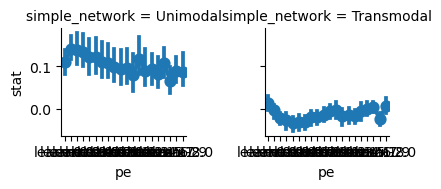

In [17]:
data = pe_df.loc[(pe_df.pe.isin(pe_descs))
                 & (pe_df.parcel.isin(attn_rois))
                 & (pe_df.model == "attn_out_avg")]

#sns.catplot(kind="point", data=data, y="stat", x="model", hue="pe", col="network", palette="inferno", dodge=True)
#plt.show()
sns.catplot(kind="point", data=data, y="stat", x="pe", col="simple_network", dodge=True, height=2)

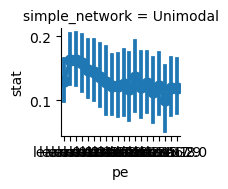

In [18]:
data = pe_df.loc[(pe_df.pe.isin(pe_descs))
                 & (pe_df.parcel.isin(pe_rois))
                 & (pe_df.model == "pe_avg")]

#sns.catplot(kind="point", data=data, y="stat", x="model", hue="pe", col="network", palette="inferno", dodge=True)
#plt.show()
sns.catplot(kind="point", data=data, y="stat", x="pe", col="simple_network", dodge=True, height=2)

# Publication figure
Stitch together in AI

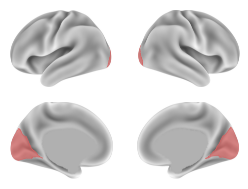

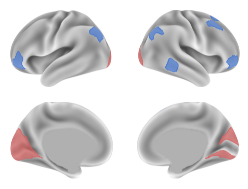

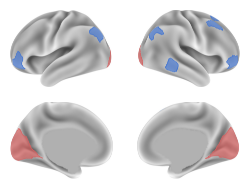

In [19]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter

plt.rcParams['svg.fonttype'] = 'none'

# analysis params
stat = "stat"
#pe ="2dpe"

for label in ["pe", "attn", "combined"]:
    # gridspec inside gridspec
    fig = plt.figure(figsize=(3.0, 2.2))

    # rows
    main_grid = gridspec.GridSpec(2, 2, figure=fig)
    b_count = 0
    for view in ['lateral', 'medial']:
        for hemi in ['left', 'right']:

            # get image
            img = plt.imread(
                f"../figures/brain_plots/PE_roi_{label}_{hemi}_{view}.jpeg")
            img_cropped = get_cropped_img(img,
                                        x_start_buffer=0,
                                        x_finish_buffer=0,
                                        y_start_buffer=0,
                                        y_finish_buffer=0)

            # get ax
            ax = fig.add_subplot(main_grid[b_count])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(img_cropped, aspect='equal', rasterized=True)
            sns.despine(left=True, bottom=True, ax=ax)
            b_count = b_count+1
    plt.savefig(f"../figures/PE_roi_plot_{label}.svg", dpi=1200)
    plt.show()

/tmp/ipykernel_159017/3719396391.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[["pe_desc", "pe_value"]] = data.pe.str.split("-", n=1, expand=True)
/tmp/ipykernel_159017/3719396391.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[["pe_desc", "pe_value"]] = data.pe.str.split("-", n=1, expand=True)
/tmp/ipykernel_159017/3719396391.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

SignificanceResult(statistic=-0.8165413533834586, pvalue=1.1247209263971732e-05)
SignificanceResult(statistic=0.35037593984962395, pvalue=0.12989410232900506)


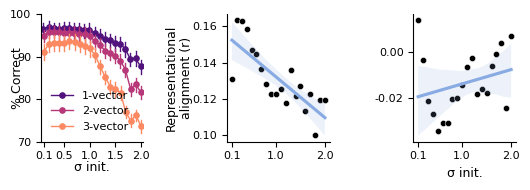

In [21]:
from scipy.stats import spearmanr


fig, axs = plt.subplots(1, 3, figsize=(5.4, 2), tight_layout=True)

ax = axs[0]
df = performance_df.copy()

# overall accuracy plot
data = df.loc[(df.phase == "test") & (df.condition != "average")]
data[["pe_desc", "pe_value"]] = data.pe.str.split("-", n=1, expand=True)
data['pe_value'] = data['pe_value'].astype(float)
data.accuracy = data.accuracy * 100
data.replace("binary", "1", inplace=True)
data.replace("ternary", "2", inplace=True)
data.replace("quaternary", "3", inplace=True)
sns.pointplot(data, x="pe_value", y="accuracy", hue_order=["1", "2", "3"],
              hue="condition", palette="magma", dodge=True, markersize=4, lw=1,
              ax=ax,
              legend=True)


# Customize legend
handles, labels = ax.get_legend_handles_labels()
custom_labels = ['1-vector', '2-vector', '3-vector']  # New labels

ax.legend(
    handles=handles,  # Skip automatic "hue" title entry
    labels=custom_labels,
    fontsize=8,
    frameon=False,  # No border
    title=None
)

ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_ylabel("% Correct", fontsize=9, labelpad=-10)
ax.set_xlabel("σ init.", fontsize=9, labelpad=0)
ax.set_xticks([0, 4, 9, 14, 19], [0.1, 0.5, 1.0, 1.5, 2.0])
ax.set_ylim([70, 100])
ax.set_yticks(range(70, 101, 10))
sns.despine(ax=ax)


ax = axs[1]
network = "Unimodal"

# gather relevant data
data = pe_df.copy()
data[["pe_desc", "pe_value"]] = data.pe.str.split("-", n=1, expand=True)
data = data.loc[(data.parcel.isin(pe_rois))
                & (data.simple_network == network)
                & (data.model == "pe_avg")].reset_index()
data = data.groupby("pe_value").mean(numeric_only=True).reset_index()
data['pe_value'] = data['pe_value'].astype(float)
print(spearmanr(data.pe_value, data.stat))
# scatter plot
sns.scatterplot(data=data, x="pe_value", y="stat", color="k", legend=False, ax=ax, s=20)

# regression line
sns.regplot(data=data, x="pe_value", y="stat", color=(0.537, 0.671, 0.890), scatter=False, ax=ax)

# parameters
ax.tick_params(axis='both', which='major', labelsize=8)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xticks([0.1, 1.0, 2.0], [0.1, 1.0, 2.0])
ax.set_xlabel("")    
ax.set_ylabel("Representational\nalignment (r)", fontsize=9, labelpad=0)
sns.despine(ax=ax)

ax = axs[2]
network = "Transmodal"

# gather relevant data
data = pe_df.copy()
data[["pe_desc", "pe_value"]] = data.pe.str.split("-", n=1, expand=True)
data = data.loc[(data.parcel.isin(attn_rois))
                & (data.simple_network == network)
                & (data.model == "attn_out_avg")].reset_index()
data = data.groupby("pe_value").mean(numeric_only=True).reset_index()
data['pe_value'] = data['pe_value'].astype(float)
print(spearmanr(data.pe_value, data.stat))
# scatter plot
sns.scatterplot(data=data, x="pe_value", y="stat", color="k", legend=False, ax=ax, s=20)

# regression line
sns.regplot(data=data, x="pe_value", y="stat", color=(0.537, 0.671, 0.890), scatter=False, ax=ax)

# parameters
ax.tick_params(axis='both', which='major', labelsize=8)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xticks([0.1, 1.0, 2.0], [0.1, 1.0, 2.0])
ax.set_xlabel("σ init.", fontsize=9)
ax.set_ylabel("")
sns.despine(ax=ax)
plt.savefig(f"../figures/PE_scatterplot.svg", dpi=1200)

# Statistics

In [29]:
# mixed anova with complexity
# average performance across seeds correlation
data = df.loc[(df.phase=="validation") & (df.condition!="average") & (df.epoch == 4000)]
data[["pe_desc", "pe_value"]] = data.pe.str.split("-", n=1, expand=True)
data['pe_value'] = data['pe_value'].astype(float)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
display(pg.rm_anova(data=data, dv="accuracy", within=["condition", "pe_value"], subject="seed", detailed=True))

/tmp/ipykernel_159017/1941749695.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[["pe_desc", "pe_value"]] = data.pe.str.split("-", n=1, expand=True)
/tmp/ipykernel_159017/1941749695.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[["pe_desc", "pe_value"]] = data.pe.str.split("-", n=1, expand=True)
/tmp/ipykernel_159017/1941749695.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,condition,1.08916,2,28,0.54458,65.70718,0.00000,0.00000,0.07416,0.93617
1,pe_value,38.15891,19,266,2.00836,65.92909,0.00000,0.00000,0.73728,0.24429
2,condition * pe_value,0.83622,38,532,0.02201,5.85063,0.00000,0.00056,0.05794,0.10404
